## Bayesian inference I - exercise 2
## Gibbs Sampling and Gaussian Mixture Models

Open the data file LabIII_data; these are the outcomes of a cancer simulation where there are a number of clones distinguished by their 2D allelic frequencies.
- visualize the data
- apply K-means to initialise the membership variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data=pd.read_csv("LabIII_data",header=0)
data

,S1,S2
0,0.511628,0.513158
1,0.481013,0.537736
2,0.500000,0.500000
3,0.504505,0.533333
4,0.540000,0.549020
...,...,...
226,0.207921,0.250000
227,0.212121,0.000000
228,0.218182,0.000000
229,0.194444,0.000000


Text(0, 0.5, 'S2')

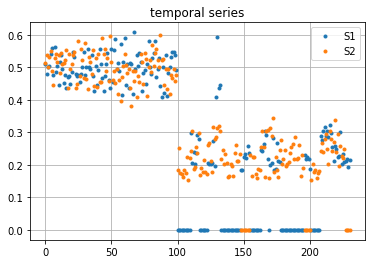

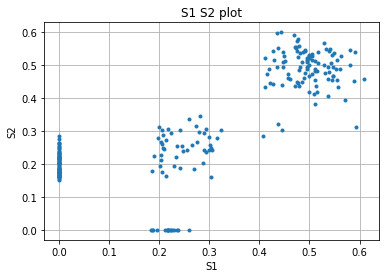

In [3]:
plt.figure()
plt.title('temporal series')
plt.plot(data['S1'],'.',label='S1')

#plt.figure()
plt.plot(data['S2'],'.',label='S2')
plt.grid()
plt.legend()

plt.figure()
plt.title('S1 S2 plot')
plt.plot(data['S1'],data['S2'],'.')
plt.grid()
plt.xlabel('S1')
plt.ylabel('S2')


k-means algorithm (from the exercise of unsupervised learning)

In [4]:
from scipy.spatial import distance_matrix

def draw(data,centroids,z,k,b,icount=0):
    data1=data[:,0]
    data2=data[:,1]
    
    plt.figure()
    for i in range(k):
        plt.plot(data1[np.where(z==i)],data2[np.where(z==i)],'o',label='%i'%i,markersize=2)
        if (b==0):
            plt.title('clustering initialization')
        else:
            plt.title('clustering at step %i'%icount)  
    plt.plot(centroids[:,0],centroids[:,1],'*k')
    plt.legend()
    
# function for k-means
# bobj=0 if you want only the objective function at the last step, 1 otherwise
# bplot=0 if you do not want plots, 1 otherwise

def kmeans(data,k,bobj=0,bplot=1):

    npatt,nfeat=data.shape
    
    # 1. randomly pick k centers
    centroids=np.zeros((k,nfeat))
    inds=np.random.choice(npatt,k,replace=False)
    for i in range(k):
        centroids[i,:]=data[inds[i],:]
        
    # 2. assign each point to its nearest center
    distances=distance_matrix(data,centroids)
    z=np.zeros(npatt) # column index of the min distance per row
    zold=np.zeros(npatt)
    z=np.argmin(distances,axis=1)
    
    if (bobj==1):
        obj=0
        for i in range(k):
            inds=np.where(z==i)
            obj=obj+np.sum(np.linalg.norm(data[inds,:]-centroids[i,:],axis=1)**2)
        objs=[obj]        
    
    if (bplot==1):
        draw(data,centroids,z,k,b=0)
       
    icount=0
    while np.any(np.not_equal(z,zold)):
        zold=z
        # 3. update the k cluster centroids based on the assigned cluster membership
        for i in range(k):
            inds=np.where(z==i)
            centroids[i,:]=np.mean(data[inds,:],axis=1)
        
        # compute the objective function at each step
        if (bobj==1):
            obj=0
            for i in range(k):
                inds=np.where(z==i)
                obj=obj+np.sum(np.linalg.norm(data[inds,:]-centroids[i,:],axis=1)**2) 
            objs.append(obj)
            
        distances=distance_matrix(data,centroids)
        z=np.argmin(distances,axis=1)
        icount+=1
        
        if (bplot==1):
            draw(data,centroids,z,k,b=1,icount=icount)
        
    if (bobj==0):
        obj=0
        for i in range(k):
            inds2=np.where(z==i)
            obj=obj+np.sum(np.linalg.norm(data[inds2,:]-centroids[i,:],axis=1)**2) 
    elif (bobj==1):
        obj=np.array(objs)
            
        
    return z,icount,obj,centroids

[3.06425512 2.03216716 1.52521523 1.38382641 1.26492435 1.02969593
 0.88958857 0.81796496 0.80222499]


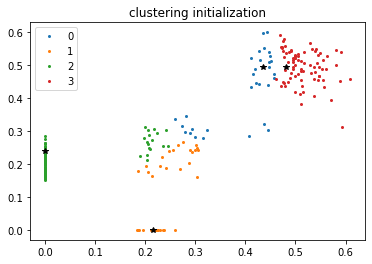

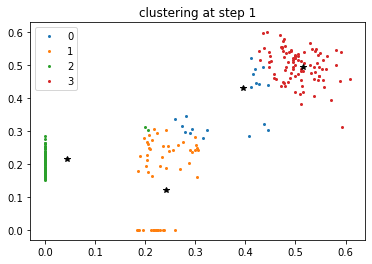

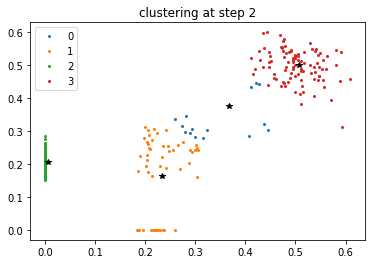

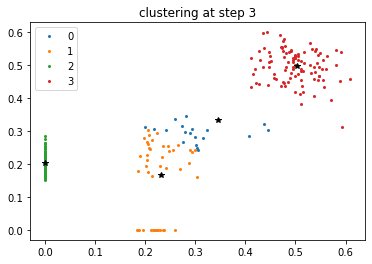

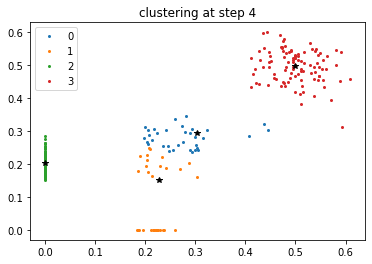

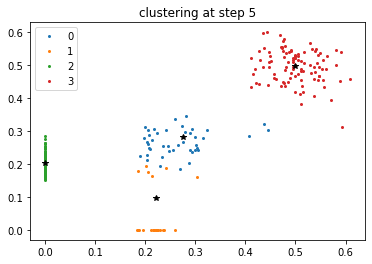

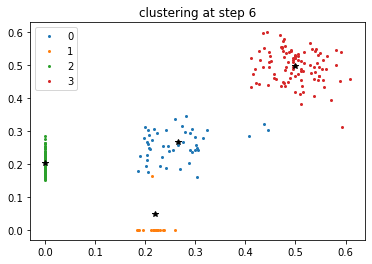

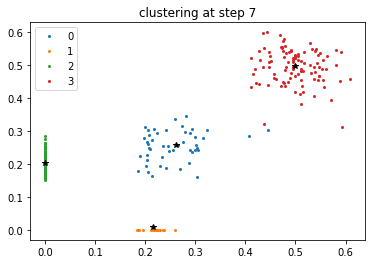

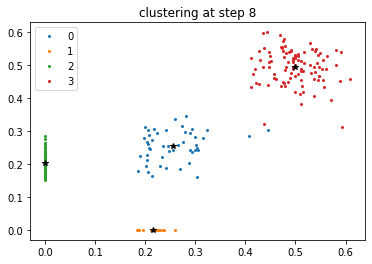

In [25]:
k=4
data=np.array(data)

z,i,obj,centroids=kmeans(data,k,bobj=1)
print(obj)

In [26]:
print(centroids)
print(z)

[[0.25569851 0.25519837]
 [0.21604216 0.        ]
 [0.         0.20329695]
 [0.49910568 0.49494805]]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1]


- use Gibbs sampling to sample from the joint posterior with the following prior parameters: $\pi$ has a $Dir(1)$ whose parameter vector is all 1s; the means of the Gaussian components all have the same prior $\mathcal N(0,1)$. The variances of the Gaussian components are fixed to 0.1.
- monitor convergence of the chain by plotting the mixture parameters $\pi$ as a function of the iteration

initialization: after k-mean,
- $\pi_0$ the probability to be in each cluster
- $z_0$ the assignations
- $\mu_0$ the averages of each cluster, taken as the centroids (approx.)

In [90]:
pi0=np.zeros(k)
for i in range(k):
    pi0[i]=np.shape(np.where(z==i))[1]/len(z)

print('pi_0:',pi0)
print('check normalization: ',np.sum(pi0))

z0=z

mus0=centroids

pi_0: [0.         0.         0.43290043 0.56709957]
check normalization:  1.0


In [91]:
mus0

array([[0.25569851, 0.25519837],
       [0.21604216, 0.        ],
       [0.        , 0.20329695],
       [0.49910568, 0.49494805]])

In [92]:
# variances of the Gaussian components
var=0.1

# parameters for Dirichlet distribution
alpha=1

In [68]:
def gaussian(x,mu,sigma):
    inv_sigma=np.linalg.inv(sigma)
    return np.sqrt(np.linalg.det(sigma)/(2*np.pi)**len(mu))*np.exp(-np.einsum('i,ij,j',x-mu,inv_sigma,x-mu))

In [93]:
print(data[i])
print(mus0)
gaussian(data[i],mus0[3,:],0.1*np.identity(2))

[0.5045045  0.53333333]
[[0.25569851 0.25519837]
 [0.21604216 0.        ]
 [0.         0.20329695]
 [0.49910568 0.49494805]]


0.01567813934276247

In [103]:
mus=mus0
z=z0

In [111]:
a=np.shape(np.where(z==i))[1]
np.random.dirichlet([1+a])

array([1.])

In [112]:
alpha=np.ones(k)


In [117]:
for niter in range(100):
    dir=np.zeros(k)
    for i in range(k):
        dir[i]=alpha[i]+np.shape(np.where(z==i))[1]
    pi=np.random.dirichlet(dir)
    print('pi: ',pi)

    for i in range(len(z0)):
        resp=np.zeros(k)
        for j in range(k):
            resp[j]=pi[j]*gaussian(data[i],mus[j,:],0.1*np.identity(2))
        resp=resp/np.sum(resp)
        cumresp=np.cumsum(resp)
        rand=np.random.rand()
        z[i]=np.argwhere(cumresp>rand)[0]

    print('z: ',z)

    mus=np.zeros((k,2))
    for i in range(k):
        c=np.shape(data[z==i])[1]*np.mean(data[z==i],axis=0)/var
        sigma=np.identity(2)*(1+np.shape(np.where(z==i))[1])
        #print(c)
        #print(sigma)
        mus[i]=np.random.multivariate_normal(c,sigma)
    print('mus: ',mus)

pi:  [0.28252262 0.17762752 0.2577598  0.28209006]


/tmp/ipykernel_21269/1898076022.py:12: RuntimeWarning: invalid value encountered in true_divide
  resp=resp/np.sum(resp)


IndexError: index 0 is out of bounds for axis 0 with size 0